### <b>Table of Content</b>

##### <b>0. Import Functions</b>

##### <b>1. Load Data</b>

##### <b>2. Exploratory Data Analysis (EDA)</b>
&emsp; 2-1. Examine the format and perform basic data manipulation<br>
&emsp; 2-2. Plot histograms and box plots to understand the distribution of each column<br>
&emsp; 2-3. Plot a correlation heatmap and analyze correlations between the target and other columns<br>
&emsp; 2-4. Perform STL to identify seasonalities in the data<br>
&emsp; 2-5. Plot autocorrelation and partial autocorrelation to see how similar the current data point is to historical data

##### <b>3. Feature Selection and Engineering</b>

##### <b>4. Train Models</b>
&emsp; 4-1. Split data into train and test sets<br>
&emsp; 4-2. Train a SARIMAX model<br>
&emsp; &emsp; 4-2-1. Perform stepwise search to find the best order with the smallest AIC<br>
&emsp; &emsp; 4-2-2. Train a SARIMAX model using the best orders found from the stepwise search above<br>
&emsp; 4-3. Train different models and compare prediction results<br>
&emsp; &emsp; 4-3-1. Train random forest and XGB regressors, in addition to a SARIMAX model<br>
&emsp; &emsp; 4-3-2. Compare model performance using different evaluation metrics, in addition to line plot

##### <b>5. Evaluate Prediction Results</b>

##### <b>6. </b> 

##### <b>7. </b>
------------------------------------------------------------------------------------------------------------------------

### <b>0. Import Functions</b>

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, seasonal_decomposition, add_features_from_previous_dates\
                            , normalize_scale
from utils.plot import plot_histograms, plot_heatmap, plot_autocorrelation
from utils.predict import train_models_and_make_predictions, get_trading_decision_and_results
from utils.evaluate import evaluate_predictions, get_capital_returns, get_capital_return_df

import warnings
warnings.simplefilter('ignore', UserWarning)

### <b>1. Load Data</b>

In [2]:
# Assign details of the source file in G Drive to local variables.
base_url = 'https://drive.google.com/file/d/'
file_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
file_url = f'{base_url}{file_id}'
file_name = '2020Q1Q2Q3Q4-2021Q1.xlsx'

# Assign details of local directories to local variables.
root_dir = sys.path[0]
download_dir = Path(root_dir) / 'data'
file_path = download_dir / file_name

# Download the file if it's not found in the file path.
if os.path.exists(file_path):
    print(f'File {file_name} already exists in {download_dir}.')
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f'File {file_name} is not found in {download_dir}.')
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

# Move back to the root directory.
if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in d:\OneDrive\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [3]:
full_sheet_names = [
    'Russia - Sberbank Rossii PAO (SBER)',
    'Turkey - Koc Holding AS (KCHOL)',
    'Egypt - Medinet Nasr Housing (MNHD)',
    'Brazil - Minerva SA/Brazil (BEEF3)',
    'Argentina - Pampa Energia SA (PAMP)',
    'Colombia - Cementos Argos SA (CCB)',
    'South Africa - Impala Platinum Holdings Ltd (IMPJ)',
    'South Korea - Dongkuk Steel Mill Co Ltd (001230)'
]
data_dfs = load_dataframes(file_path, full_sheet_names)

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


### <b>2. Exploratory Data Analysis (EDA)</b>

#### <b>2-1. Examine the format and perform basic data manipulation</b>

We have loaded 8 DataFrames (for 8 different stocks) but the format of each of the DataFrames should be the same.<br>
Have a look at the first one.

In [4]:
first_df = data_dfs[full_sheet_names[0]]
print('Basic info of the first DateFrame:\n')
print(first_df.info())
print('\n')
print('Tail of the first DataFrame:\n')
print(first_df.tail())

Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Tail of the first DataFrame:

          Date   Price    Open    High     Low    Vol.  Change %
306 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
307 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
308 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
309 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
310 2020-01-

- Since we have time-series data, set the 'Date' column as index.
- The dtype of the 'Vol.' column is object, which needs to be converted to either integer or float so that the values are machine-readable, in other words so that they can be used as a training feature.
- Additionally, the 'Price' column will be the target to be predicted, which is the closing price for each trading date.

In [5]:
df = first_df.set_index('Date').sort_index()
df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071


#### <b>2-2. Plot histograms and box plots to understand the distribution of each column</b>

Distribution of target 'Price' and dependent variables:


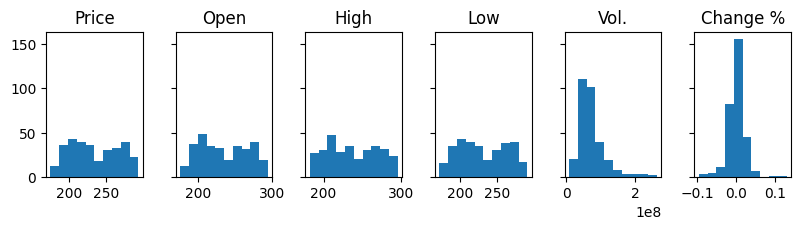

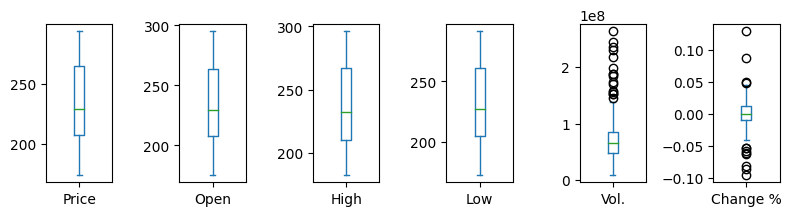

In [6]:
plot_histograms(data=df,
                target='Price', target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

- The 'Vol.' column is right-skewed.
- The 'Change %' column is roughly normally distributed.
- The 'Vol.' and 'Change %' columns have many outliers. 
- The other columns show bimodal distributions without outliers.

#### <b>2-3. Plot a correlation heatmap and analyze correlations between the target and other columns</b>

,Price,Open,High,Low,Vol.,Change %
Price,1.000000,0.992246,0.996541,0.995765,-0.245279,0.089939
Open,0.992246,1.000000,0.996392,0.996370,-0.262197,-0.014046
High,0.996541,0.996392,1.000000,0.994497,-0.215092,0.034574
Low,0.995765,0.996370,0.994497,1.000000,-0.291138,0.037396
Vol.,-0.245279,-0.262197,-0.215092,-0.291138,1.000000,0.044594
Change %,0.089939,-0.014046,0.034574,0.037396,0.044594,1.000000


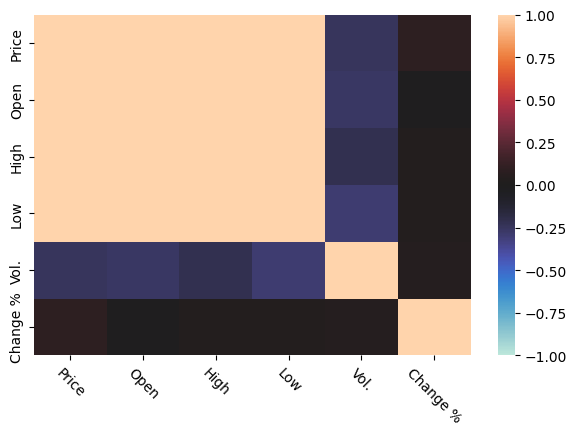

In [12]:
plot_heatmap(df.corr(), figsize=(6, 4), rotate_xticks=-45, corr_df=True, vmin=-1, vmax=1, center=0)
df.corr()

- The correlation between the 'Change %' and the target (i.e. 'Price') column is very low - less than 0.1.
- The correlation between the 'Vol.' and 'Price' columns is also pretty low - the absolute value of it is less than 0.3.
- Thus, these two columns would not be useful in training a predictive model.

#### <b>2-4. Perform STL to identify seasonalities in the data</b>

STL (Seasonal and Trend decomposition using LOESS) is a versatile and robust method for decomposing time series.<br>
\* LOESS (Locally Estimated Scatterplot Smoothing) is a nonparametric method, where no assumptions are made about the underlying structure of a series of data, for estimating nonlinear relationships. It uses local regression to fit a smooth curve through a scatterplot of data.

Although STL can capture general patterns without assuming data, it does not automatically handle trading day or calendar variation, and it only provides facilities for additive decompositions.

Plotting seasonal componets:


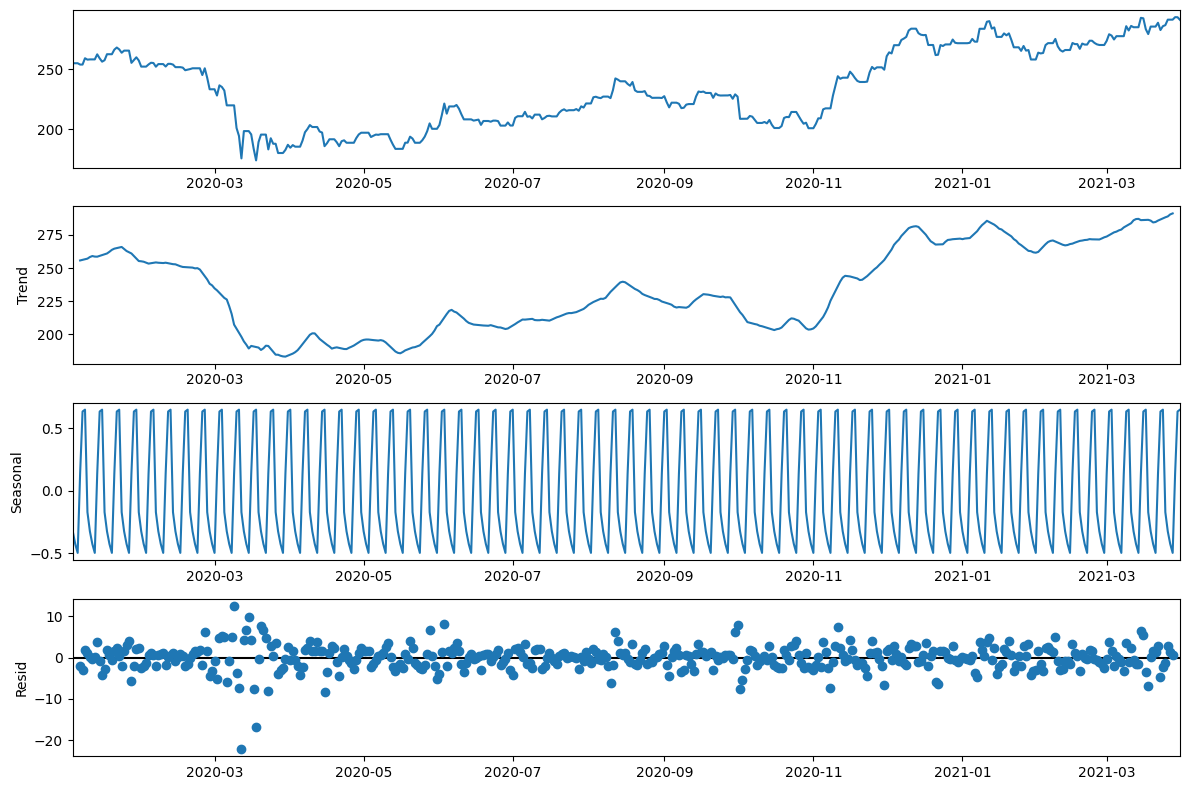

In [8]:
seasonal_decomposition(df=df, frequency='D', column='Price', add_to_df=False, plot=True)

- The original data and the Trend component (i.e. the first and second plots) look very similar, indicating seasonality in the time series data is not significant.
- The patterns observed from the Seasonal plot are likely due to the regularity of the trading dates - i.e. No trading data during weekends and almost the same seasonal pattern is observed on a weekly basis.
- Most of the residuals (i.e. the Resid plot) are centered around 0 with not a lot of data points whose absolute values are greater than 10.

#### <b>2-5. Plot autocorrelation and partial autocorrelation to see how similar the current data point is to historical data</b>

The ACF (Auto-Correlation Function) returns autocorrelations over time where variability can be explained by multiple points in time.<br>
Whereas, the PACF (Partial ACF) returns partial autocorrelation for each point in time, that is, only the additional autocorrelation between the current and previous points in time.

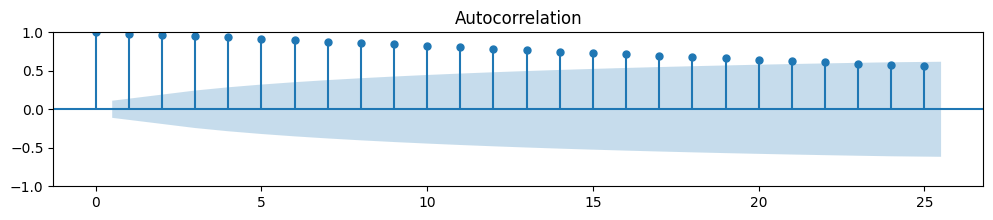

In [9]:
plot_autocorrelation(df, 'Price', partial=False)

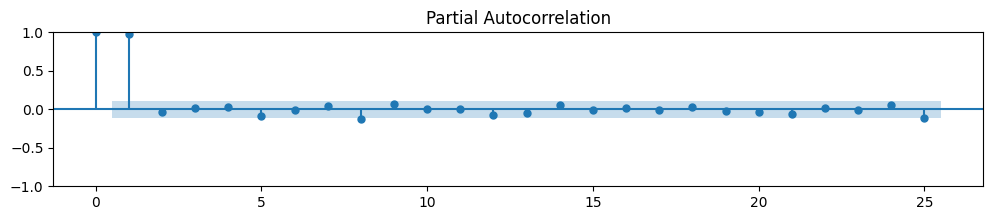

In [10]:
plot_autocorrelation(df, 'Price', partial=True)

The next day (i.e. where the X value in the plot is 1) has an autocorrelation of almost 1, meaning only the previous day would be relevant to today. To put it differently, most past data except for yesterday's data may not be helpful in predicting today's data, in our case today's closing price (i.e. the 'Price' column).

The blue area in the ACF and PACF plots depicts the 95% confidence interval, meaning anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

### <b>3. Feature Selection and Engineering</b>

1. 'Vol.' and 'Change %' are not relevant based on correlation coefficients with the target column 'Price', so they will be dropped for the next steps.
2. Only the previous date's price is highly correlated with today's price based on autocorrelation, but simple moving averages over the week will also be used as training features in addition to the data from the previous date so that trends can be captured and learned by the model.

In [11]:
concat_df = add_features_from_previous_dates(df)

# Drop the target column and the columns that will not be available when making predictions
X = concat_df.drop(['Price'], axis=1)
print("Training features:")
print(*list(X.columns), sep='\n')

y = concat_df['Price']
print("\nTarget: Price")

Training features:
Price (Day-1)
Open (Day-1)
High (Day-1)
Low (Day-1)
2 Day SMA Price (Day-1)
3 Day SMA Price (Day-1)
4 Day SMA Price (Day-1)
5 Day SMA Price (Day-1)
6 Day SMA Price (Day-1)
7 Day SMA Price (Day-1)

Target: Price


All training features are highly correlated with the target 'Price' according to the correlation heatmap below.

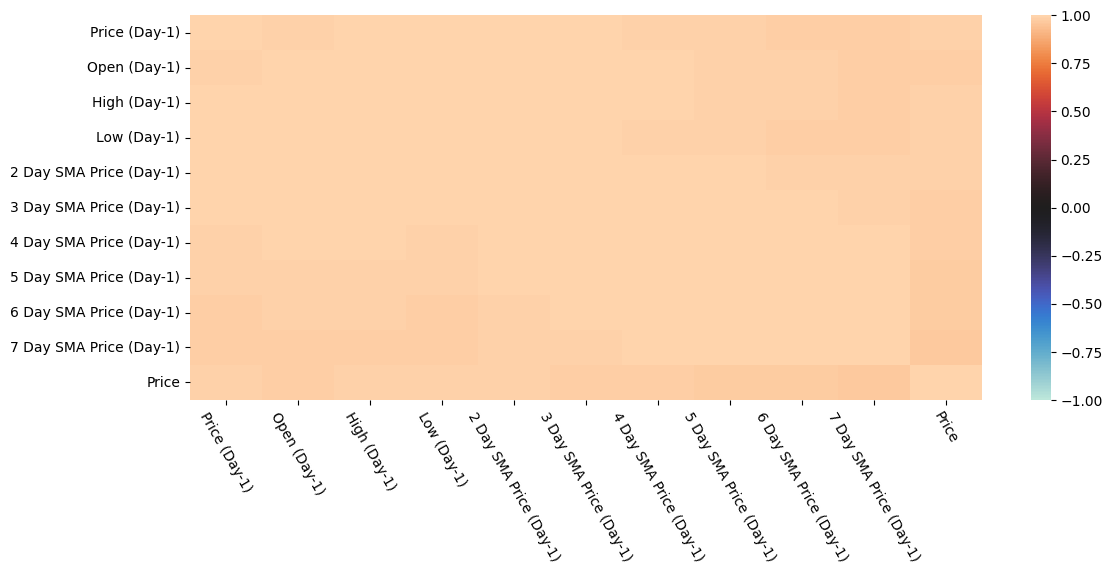

In [12]:
plot_heatmap(pd.concat([X, y], axis=1).corr(), figsize=(12, 6), rotate_xticks=-60, corr_df=True,
             vmin=-1, vmax=1, center=0)

### <b>4. Train Models</b>

#### <b>4-1. Split data into train and test sets</b>

In [13]:
X_train = X[X.index.year == 2020]
X_test = X[X.index.year == 2021]

y_train = y[y.index.year == 2020]
y_test = y[y.index.year == 2021]

#### <b>4-2. Train a SARIMAX model</b>

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is a versatile time series model that considers both non-seasonal and seasonal components, as well as exogenous variables. It is particularly useful when dealing with time series data that exhibits seasonality and requires differencing to achieve stationarity. The model leverages autoregressive, differencing, and moving average terms to capture the underlying patterns and make forecasts.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous (the 'X' in SARIMAX) variables allows for the incorporation of additional factors that may influence the time series.

A SARIMAX model is typically denoted as SARIMAX (p, d, q) (P, D, Q, s), where:
- p, d, and q are the orders of the non-seasonal AR (i.e. the number of autoregressive terms), differencing (i.e. the number of non-seasonal differences needed for stationarity), and MA (i.e. the number of lagged forecast errors in the prediction equation) components, respectively.
- P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
- Exogenous variables can be included in the model by specifying them separately.

\* Further breakdown of the terms related to SARIMAX:

1. Stationarity:
A stationary time series is one whose statistical properties (e.g., mean, variance) remain constant over time. In a non-stationary time series, these properties change over time, making it difficult to model and predict. To make the time series stationary, we often take the difference between consecutive observations, known as differencing. This helps to remove trends and seasonality, making the data more amenable to modeling.

2. Autoregressive (AR) Terms:
The autoregressive component of the SARIMAX model refers to the relationship between the current value of the time series and its past values. In other words, the value at a given time point is modeled as a linear combination of the previous observations with appropriate coefficients. The "AR(p)" term indicates the number of past observations (lags) considered in the model.

3. Differencing Terms (I - Integrated):
The "I" in SARIMAX stands for integrated, which relates to the differencing mentioned earlier. The integration order "d" represents the number of times differencing is applied to achieve stationarity. If "d=1", it means one level of differencing was used, and if "d=2", it means the series was differenced twice, and so on.

4. Moving Average (MA) Terms:
The moving average component of the SARIMAX model accounts for the relationship between the current value of the time series and the past forecast errors. The "MA(q)" term indicates the number of past forecast errors considered in the model.

5. Seasonal Components (S):
Many time series exhibit seasonal patterns, such as quarterly sales, monthly temperature variations, etc. SARIMAX models account for these seasonal patterns using seasonal autoregressive and moving average terms. The seasonal autoregressive term is denoted by "SAR(P)", and the seasonal moving average term is denoted by "SMA(Q)". The capital letters "P" and "Q" represent the seasonal autoregressive and moving average orders, respectively.

6. Exogenous Variables (X):
The "X" in SARIMAX denotes that this model allows for the inclusion of exogenous variables. Exogenous variables are additional input variables that may influence the time series but are not affected by it. These variables can improve the model's forecasting accuracy by capturing external factors that impact the time series.

##### 4-2-1. Perform stepwise search to find the best order with the smallest AIC

The AIC (Akaike's information Criterion) is a widely used measure of a statistical model. This metric quantifies the goodness of fit and simplicity of the model into a single statistic. When comparing two models, the one with the lower AIC is considered to be better.

In [14]:
search_result=auto_arima(y_train, 
                    exogenous= X_train,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
search_result.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464.557, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1461.760, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1463.283, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1463.233, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1459.800, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.585 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -728.900
Date:                Sat, 22 Jul 2023   AIC                           1459.800
Time:                        17:31:46   BIC                           1463.289
Sample:                             0   HQIC                          1461.206
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.1937      1.313     18.428      0.000      21.620      26.767
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               134.83
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 4-2-2. Train a SARIMAX model using the best orders found from the stepwise search above

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  243
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -716.458
Date:                Sat, 22 Jul 2023   AIC                           1454.916
Time:                        17:31:47   BIC                           1493.294
Sample:                             0   HQIC                          1470.376
                                - 243                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Price (Day-1)               0.0015      0.152      0.010      0.992      -0.296       0.299
Open (Day-1)               -0.2741      0.146     -1.883      0.060      -0.559       0.011


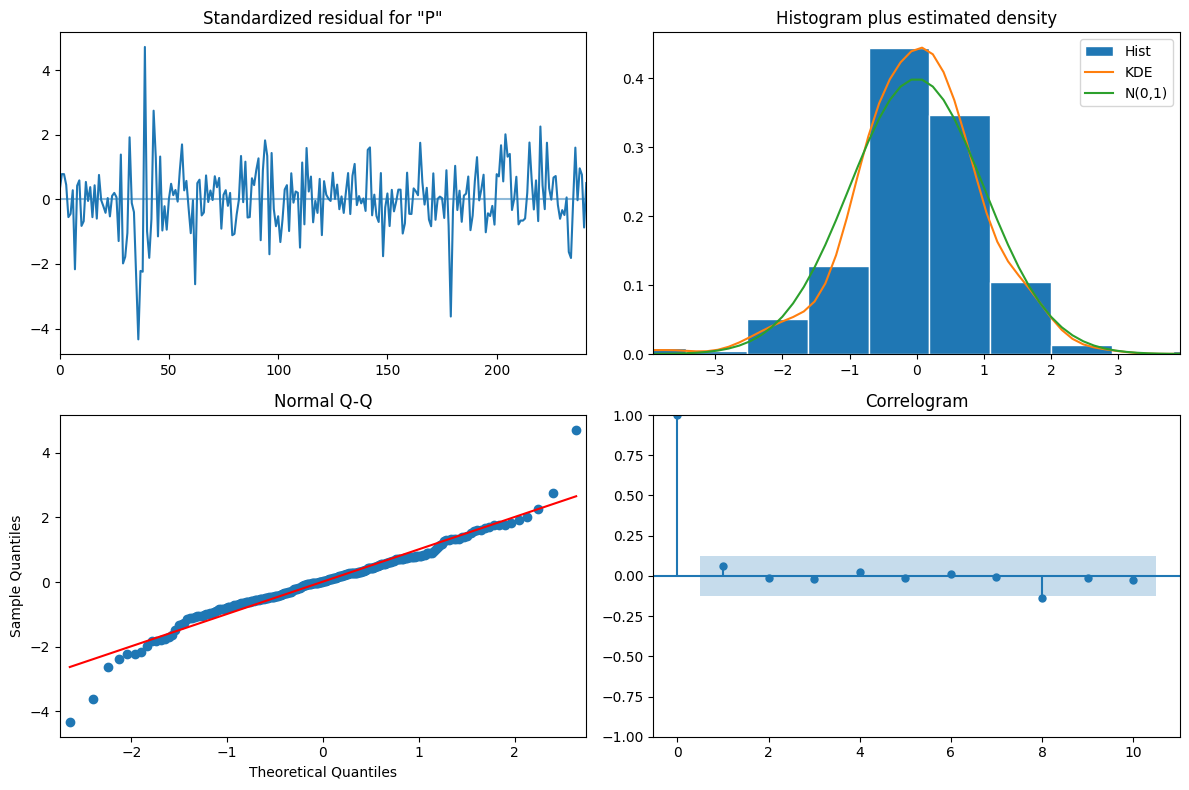

In [15]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

sarimax_model = SARIMAX(
    endog = y_train,
    exog = X_train,
    order=search_result.order, # (0, 1, 0)
    seasonal_order=search_result.seasonal_order # (0, 0, 0, 0)
    )
fit_result = sarimax_model.fit(disp=False)
print(fit_result.summary())

fit_result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal (0,1) density plotted for reference
3. Normal Q-Q plot, with Normal reference line
4. Correlogram

#### <b>4-3. Train different models and compare prediction results</b>

##### 4-3-1. Train random forest and XGB regressors, in addition to a SARIMAX model

The SARIMAX model above might work well but try training two other models (that is, random forest and XGB regressors, both of which are widely used) just in case it doesn't work as expected.

For training, the whole train data and part of the test data will be used at each step (i.e. for each row) so that the time series predictions can be more timely, thus more accurate. For example, to make a prediction for the date of Jan 5, 2021, the whole data from 2020 plus the data up to Jan 4, 2021 (if it exists in the data set) will be used for training.

In [16]:
random_state = 5
preds_df = train_models_and_make_predictions(X_train, y_train, X_test, y_test, random_state)
preds_df.head()

100%|██████████| 61/61 [00:58<00:00,  1.05it/s]


,Price,SARIMAX,RandomForestRegressor,XGBRegressor
Date,,,,
2021-01-04,272.00,272.065064,267.438770,277.448181
2021-01-05,275.20,273.228012,267.903785,272.790466
2021-01-06,272.93,275.635722,268.368358,275.882263
2021-01-08,283.64,272.224619,268.884473,274.682220
2021-01-11,289.49,286.083463,269.907792,282.125916


##### 4-3-2. Compare model performance using different evaluation metrics, in addition to line plot

,Model,Mean Squared Error,Mean Absolute Percentage Error,R2 Score
0,SARIMAX,19.376120,0.012779,0.765763
1,RandomForestRegressor,95.672374,0.027844,-0.156579
2,XGBRegressor,37.454176,0.018158,0.547218


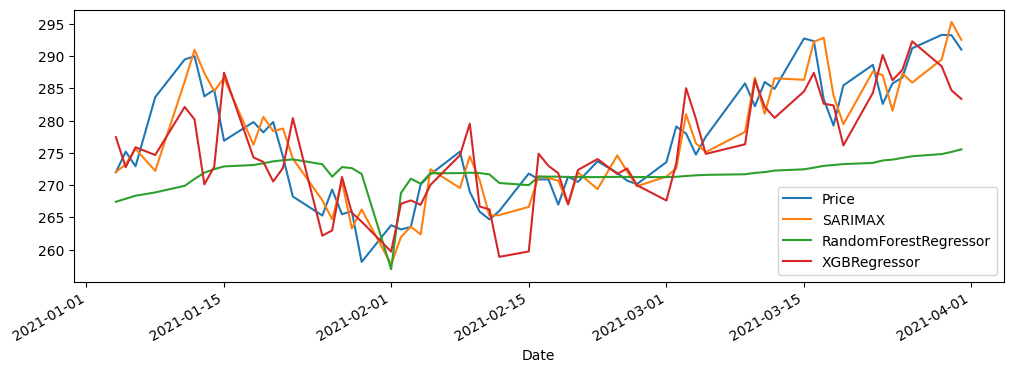

In [17]:
evaluate_predictions(y_test, preds_df,
                     keys=['SARIMAX', 'RandomForestRegressor', 'XGBRegressor'], plot_df=True)

The predictions from both the SARIMAX and XGBRegressor seem to be close to the target 'Price' according to the line plot above.<br>
However, the SARIMAX model's predictions were a lot better based on the three evaluation metrics used - i.e. smaller mean squared error, smaller mean absolute percentage error, and greater R2 score.<br>
Hence, the SARIMAX model's predictions will be used to make trading decisions on the next steps.

### <b>5. Evaluate Prediction Results</b>

#### 5-1. Create Bollinger Bands and compare it with the SARIMAX predictions to make trading decisions

* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.


Bollinger Band seem not useful since all predicted values are within the band.

Thus, use 20-day SMA to determine trading decision as follows:
* if the predicted price is lower than the SMA —> buy
* if the predicted price is higher than the SMA —> sell
* if within the Bollinger band, hold.

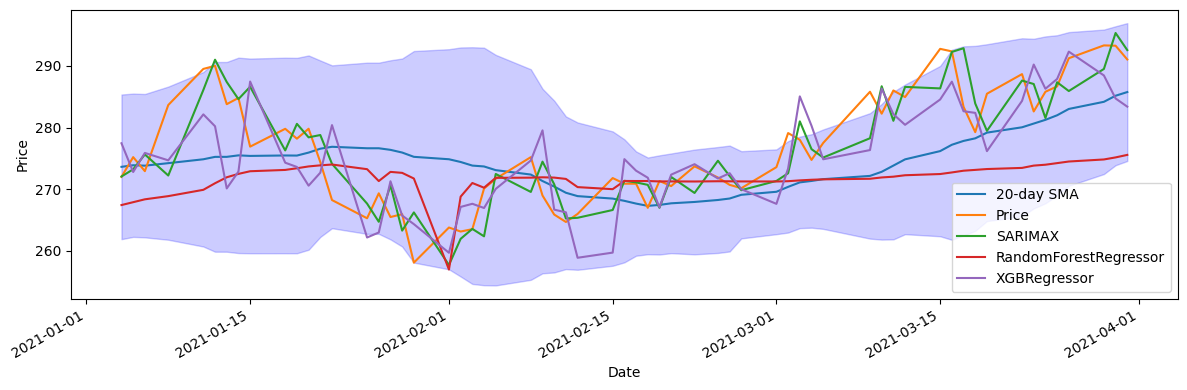

In [18]:
bollinger_band_window = 20
bollinger_band_std = 2

rolling_mean = y.rolling(window=bollinger_band_window).mean().loc[y_test.index]
rolling_std = y.rolling(window=bollinger_band_window).std().loc[y_test.index]

ax = rolling_mean.plot(label=f'{bollinger_band_window}-day SMA', figsize=(12, 4))
upper_band = (rolling_mean + (rolling_std * bollinger_band_std)).rename('Upper Band')
lower_band = (rolling_mean - (rolling_std * bollinger_band_std)).rename('Lower Band')

# y_test.plot(ax=ax, label='Price')
# pred_mean.plot(ax=ax, label='Predicted', alpha=.7)
preds_df.plot(ax=ax)

ax.fill_between(y_test.index,
                lower_band,
                upper_band,
                color='b', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

5-1. Get trading dates

In [19]:
daily_trading_dates = y_test.index # Trade every 1 trading day
weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days

#### 5-2. Evaluate results of the training decisions based on the predictions

Use the predictions from the SARIAX model for making trading decisions since the performance of it was better than the others.

In [20]:
results_df = pd.concat([y_test,
                        preds_df['SARIMAX'].rename('Predicted'),
                        rolling_mean.rename('20-day SMA'),
                        upper_band,
                        lower_band
                        ],
                        axis=1)
results_df

,Price,Predicted,20-day SMA,Upper Band,Lower Band
Date,,,,,
2021-01-04,272.00,272.065064,273.6285,285.342686,261.914314
2021-01-05,275.20,273.228012,273.8885,285.493915,262.283085
2021-01-06,272.93,275.635722,273.8170,285.427803,262.206197
2021-01-08,283.64,272.224619,274.2245,286.627575,261.821425
2021-01-11,289.49,286.083463,274.8545,288.987067,260.721933
...,...,...,...,...,...
2021-03-25,286.66,287.328485,281.9810,294.947321,269.014679
2021-03-26,291.22,285.907487,283.0065,295.453327,270.559673
2021-03-29,293.30,289.484213,284.1630,295.863807,272.462193


Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Predicted (Price)'.

In [21]:
predicted_results_dfs = get_trading_decision_and_results(
    daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
    results_df, benchmark_col='20-day SMA', compare_against_col='Predicted',
    initial_balance=0, initial_no_stock=0, max_no_stock_to_trade=1,
    ignore_upper_lower=True
)
pd.DataFrame.from_dict(get_capital_returns(predicted_results_dfs), orient='index', columns=['Predicted'])

,Predicted
Daily Return Total,117.17
Weekly Return Total,7.39
Monthly Return Total,15.95


Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Price'.

In [22]:
price_results_dfs = get_trading_decision_and_results(
    daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
    results_df, benchmark_col='20-day SMA', compare_against_col='Price',
    initial_balance=0, initial_no_stock=0, max_no_stock_to_trade=1,
    ignore_upper_lower=True
)
pd.DataFrame.from_dict(get_capital_returns(price_results_dfs), orient='index', columns=['Price'])

,Price
Daily Return Total,150.31
Weekly Return Total,22.24
Monthly Return Total,15.95


In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

def process_df(df, bollinger_band_window=20, bollinger_band_std=2,
               prediction_col='Predicted', compare_against_col='Price',
               plot_histogram=False, plot_bollinger_band=False, random_state=5,
               smooth_predictions=False, smoothing_level=0.1,
               normalize_X=False, previous_date_range=[2, 3, 4, 5, 6, 7]):
    # 2-1. Examine the format and perform basic data manipulation
    df = df.set_index('Date').sort_index()
    df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)

    if plot_histogram:
        plot_histograms(data=df,
                        target='Price', target_figsize=(2,2),
                        dependent_layout=(2,9), dependent_figsize=(12, 4),
                        include_boxplots=True)

    # 3. feature selection and engineering
    concat_df = add_features_from_previous_dates(df, previous_date_range=previous_date_range)

    # Drop the target column and the columns that will not be available when making predictions
    X = concat_df.drop(['Price'], axis=1)
    # print("Training features:")
    # print(*list(X.columns), sep='\n')

    y = concat_df['Price']
    # print("\nTarget: Price")

    # 4-1. train-test split
    X_train = X[X.index.year == 2020]
    X_test = X[X.index.year == 2021]

    y_train = y[y.index.year == 2020]
    y_test = y[y.index.year == 2021]

    if normalize_X:
        X_train, X_test, scaler = normalize_scale(X_train, X_test, method="standard", exclude_column=None)

    # 4-2. Perform stepwise search to find the best order with the smallest AIC
    # step_wise=auto_arima(y_train, 
    #                     exogenous= X_train,
    #                     start_p=1, max_p=7, 
    #                     start_q=1, max_q=7, 
    #                     d=1, max_d=7,
    #                     trace=True, 
    #                     error_action='ignore', 
    #                     suppress_warnings=True, 
    #                     stepwise=True)
    # print(f'ARIMA order: {step_wise.order}')
    # print(f'SARIMA order: {step_wise.seasonal_order}')
    # => This returns the same orders for all stocks.

    # 4-3. Train a SARIMAX model
    result_dfs = []
    for i in tqdm(range(0, len(X_test))):
        new_X_train = pd.concat([X_train, X_test[:i]])
        new_y_train = pd.concat([y_train, y_test[:i]])
        new_X_test = X_test[i:i+1]
        new_y_test = y_test[i:i+1]

        result_df = pd.DataFrame(new_y_test)

        sarimax_model = SARIMAX(
            endog = new_y_train,
            exog = new_X_train,
            order = (0, 1, 0),
            seasonal_order = (0, 0, 0, 0)
            )
        results = sarimax_model.fit(disp=False)
        pred = results.get_prediction(start=new_X_train.shape[0],
                                    end=new_X_train.shape[0] + new_X_test.shape[0] - 1,
                                    exog=new_X_test)
        pred_mean = pred.predicted_mean
        pred_mean.index = new_X_test.index
        result_df['Predicted'] = pred_mean.values
        result_dfs.append(result_df)
    sarimax_pred = pd.concat(result_dfs)['Predicted']
    
    # sarimax_model = SARIMAX(
    #     endog = y_train,
    #     exog = X_train,
    #     order= (0, 1, 0), # step_wise.order,
    #     seasonal_order=(0, 0, 0, 0) # step_wise.seasonal_order
    #     )
    # results = sarimax_model.fit(disp=False)
    # pred = results.get_prediction(start=X_train.shape[0],
    #                               end=X_train.shape[0] + X_test.shape[0] - 1,
    #                               exog=X_test)
    # sarimax_pred = pred.predicted_mean
    # sarimax_pred.index = X_test.index
    
    # Compare performance of different models
    sarimax_mse = mean_squared_error(y_test, sarimax_pred)
    sarimax_mape = mean_absolute_percentage_error(y_test, sarimax_pred)
    sarimax_r2 = r2_score(y_test, sarimax_pred)
    print(f'''SARIMAX model:
    Mean Squared Error: {round(sarimax_mse, 4)}
    Mean Absolute Percentage Error: {round(sarimax_mape, 4)}
    R2 Score: {round(sarimax_r2, 4)}
    ''')

    best_model = 'SARIMAX'
    best_predictions = sarimax_pred
    best_mse = sarimax_mse
    best_r2 = sarimax_r2

#     # Train non-timeseries regression models
#     rf_reg = RandomForestRegressor(max_depth=2, random_state=random_state)
#     rf_reg.fit(X_train, y_train)
#     rf_pred = rf_reg.predict(X_test)
#     rf_pred = pd.Series(rf_pred, index=X_test.index)

#     rf_mse = mean_squared_error(y_test, rf_pred)
#     rf_r2 = r2_score(y_test, rf_pred)
#     # print(f'''RandomForestRegressor:
#     # Mean Squared Error: {rf_mse}
#     # R2 Score: {rf_r2}
#     # ''')

#     if (rf_mse < best_mse) and (rf_r2 > best_r2):
#         best_model = 'RandomForestRegressor'
#         best_predictions = rf_pred
#         best_mse = rf_mse
#         best_r2 = rf_r2
    
#     xgb_reg = XGBRegressor(random_state=random_state)
#     xgb_reg.fit(X_train, y_train)
#     xgb_pred = xgb_reg.predict(X_test)
#     xgb_pred = pd.Series(xgb_pred, index=X_test.index)

#     xgb_mse = mean_squared_error(y_test, xgb_pred)
#     xgb_r2 = r2_score(y_test, xgb_pred)
#     # print(f'''XGBRegressor:
#     # Mean Squared Error: {xgb_mse}
#     # R2 Score: {xgb_r2}
#     # ''')

#     # if (xgb_mse < best_mse) and (xgb_r2 > best_r2):
#     best_model = 'XGBRegressor'
#     best_predictions = xgb_pred
#     best_mse = xgb_mse
#     best_r2 = xgb_r2

#     print(f"""
# Best model is {best_model} with a mean squared error of {round(best_mse, 4)} and an R2 scroe of {round(best_r2, 4)}.
#           """)

    if smooth_predictions:
        from statsmodels.tsa.api import SimpleExpSmoothing
        ses = SimpleExpSmoothing(best_predictions)
        ses.fit(smoothing_level=smoothing_level)
        ses_predictions = pd.Series(ses.predict(ses.params, start=0, end=None), index=best_predictions.index)
        final_predictions = ses_predictions
        prediction_col = 'Smoothed Predictions'
    else:
        final_predictions = best_predictions

    # 5. Create Bollinger Bands and compare it with the SARIMAX predictions to make trading decisions.
    rolling_mean = y.rolling(window=bollinger_band_window).mean().loc[y_test.index]
    rolling_std = y.rolling(window=bollinger_band_window).std().loc[y_test.index]

    upper_band = (rolling_mean + (rolling_std * bollinger_band_std)).rename('Upper Band')
    lower_band = (rolling_mean - (rolling_std * bollinger_band_std)).rename('Lower Band')

    if plot_bollinger_band:
        ax = y_test.plot(label='Price', figsize=(12, 4))
        best_predictions.plot(ax=ax, label='Predicted', alpha=.7)
        if smooth_predictions:
            ses_predictions.plot(ax=ax, label='Smoothed Predictions')

        rolling_mean.plot(ax=ax, label=f'{bollinger_band_window}-day SMA')
        ax.fill_between(y_test.index,
                        lower_band,
                        upper_band,
                        color='b', alpha=.2)
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')

        plt.legend()
        plt.tight_layout()
        plt.show();

    # 5-1. Get trading dates    
    daily_trading_dates = y_test.index # Trade every 1 trading day
    weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
    monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days

    # 5-2. Evaluate results of the training decisions based on the predictions
    results_df = pd.concat([y_test,
                            rolling_mean.rename(f'{bollinger_band_window}-day SMA'),
                            final_predictions.rename(prediction_col),
                            upper_band,
                            lower_band
                            ],
                            axis=1)
    
    capital_return_df = get_capital_return_df(
        results_df, daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
        benchmark_col=f'{bollinger_band_window}-day SMA',
        prediction_col=prediction_col,
        compare_against_col=compare_against_col
        )
    
    return capital_return_df

In [24]:
for sheet_name in full_sheet_names:
    df = data_dfs[sheet_name]
    # print(df)
    print(f'Process time series data for {sheet_name}...')
    print('Make predictions and calculate capital return...')
    print('Result:')
    print(process_df(df,
                     bollinger_band_window=20, bollinger_band_std=0.5, plot_bollinger_band=True,
                     previous_date_range=[2, 3, 4, 5, 6, 7]))
    print('--------------------------------------------------------------------------')

Process time series data for Russia - Sberbank Rossii PAO (SBER)...
Make predictions and calculate capital return...
Result:


NameError: name 'tqdm' is not defined

### <b>5. Train a model</b>

* for nan values, you could consider discarding them if you have enough data.
Or you could plot the data to see how the nan values can be filled (e.g. average, ffill, bfill, etc.). It could be hard to figure this out, so it such cases, could just drop the nan values becausing imputing can bring bias that might not be helpful to the model/predictions.

if the predicted price is lower than the lowerbound =>  buy
if the predicted price is within the Bollinger band => hold
if the predicted price is higher than the upperbound— => sell

1 train a model and predict on a daily, weekly and monthly basis.

2 calculate threshold/uncertainty (of the prediction) (+ bollinger band of the observed data?)<br>
Typical values used:<br>
Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)<br>
Medium term: 20 day moving average, bands at 2 standard deviations.<br>
Long term: 50 day moving average, bands at 2.5 standard deviations.<br>
                                                       
3 decide to buy/hold/sell based on the threshold

4 store the value/profit if I had traded based on the decision. (also need to define how many money/stock I already have.)

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

From Semih:

Typically bollinger bands are used to make buy and sell decisions if the predicted price is lower than the lowerbound—> buy if the predicted price is higher than the upperbound—> sell

My interpretation is (the way I would approach) we can use bollinger bands to label the data. Afterwards a classifier or a recommendation system could be developed to predict buy and sell decisions. Based on the recommended actions a loss or profit could be calculated. I don’t think there is only one approach but this is how I would approach it.